Firsly we import the modules we are going to use for these tests:

In [1]:
import numpy as np
import numba
import perfplot

The best possible score algorithm calculates the maximum possible score that could be obtained from the rows of patterns provided.

* Numpy version of the algorithm

In [2]:
def calculate_best_possible_score_numpy(patterns):
    npatterns: int = patterns.shape[0]
    ncols: int = patterns.shape[1]
        
    matrix = np.zeros((ncols, ncols), dtype=np.int64)

    # Non-parallel version of the original algorithm
    for p in range(0, npatterns):
        for i in range(0, ncols):
            ival: int = patterns[p, i]

            if ival != -1:
                for j in range(i+1, ncols):
                    jval: int = patterns[p, j]

                    if jval != -1 and ival != jval:
                        matrix[i, j] = 1
                        
    score: int = np.sum(matrix)                 

    return score

* Numba jitted version of the algorithm

In [3]:
@numba.jit(nopython=True, nogil=True, fastmath=True, cache=True)
def calculate_best_possible_score_numba_nonparallel(patterns):
    npatterns: int = patterns.shape[0]
    ncols: int = patterns.shape[1]
        
    matrix = np.zeros((ncols, ncols), dtype=np.int64)

    for p in range(0, npatterns):
        for i in range(0, ncols):
            ival: int = patterns[p, i]

            if ival != -1:
                for j in range(i+1, ncols):
                    jval: int = patterns[p, j]

                    if jval != -1 and ival != jval:
                        matrix[i, j] = 1
                        
    score: int = np.sum(matrix)                 

    return score

* Parallel version of the numba algorithm

In [4]:
@numba.jit(nopython=True, nogil=True, fastmath=True, parallel=True, cache=True)
def calculate_best_possible_score_numba(patterns):
    npatterns: int = patterns.shape[0]
    ncols: int = patterns.shape[1]

    nthreads: int = numba.config.NUMBA_NUM_THREADS
    chunk_size: int = int(npatterns / nthreads) + 1
    
    thread_matrix = np.zeros((nthreads, ncols, ncols), dtype=np.int64)

    for thread_id in numba.prange(0, nthreads):
        matrix = thread_matrix[thread_id]

        for p in range(thread_id*chunk_size, min(npatterns, (thread_id+1)*chunk_size)):
            for i in range(0, ncols):
                ival: int = patterns[p, i]

                if ival != -1:
                    for j in range(i+1, ncols):
                        jval: int = patterns[p, j]

                        if jval != -1 and ival != jval:
                            matrix[i, j] = 1

    score: int = 0

    for i in range(0, ncols):
        for j in range(i+1, ncols):
            for t in range(0, nthreads):
                if thread_matrix[t, i, j] != 0:
                    score += 1
                    break

    return score

* Rearrange the loops to allow the score calculations to end early once a "1" cell is found

In [5]:
@numba.jit(nopython=True, nogil=True, parallel=True, fastmath=True, cache=True)
def calculate_best_possible_score_earlyend_matrix(patterns):
    npatterns: int = patterns.shape[0]
    ncols: int = patterns.shape[1]
        
    matrix = np.zeros((ncols, ncols), dtype=np.int64)

    # Build up matrix with filled cells to allow parallelisation
    for i in numba.prange(0, ncols):
        for j in range(0, i):
            for p in range(0, npatterns): # Striding here, so cache misses more likely. Transposing the matrix first may be faster.
                ival: int = patterns[p, i]
                jval: int = patterns[p, j]
                if ival != -1 and jval != -1 and ival != jval:
                    matrix[i, j] = 1
                    break # stop early if cell contains a one

    score: int = np.sum(matrix)
                    
    return score

* Flatten array indices to even out the length of each parallelised iteration

In [6]:
@numba.jit(nopython=True, nogil=True, parallel=True, fastmath=True, cache=True)
def calculate_best_possible_score_earlyend_matrix_flatindex(patterns):
    npatterns: int = patterns.shape[0]
    ncols: int = patterns.shape[1]
        
    matrix = np.zeros((ncols, ncols), dtype=np.int64)
    indices = np.triu_indices(ncols)
    
    # As the j loop is often much shorter than the i loop we can make each parallel iteration more even by flattening out the indices
    nindex: int = indices[0].shape[0]

    for idx in numba.prange(0, nindex):
        i = indices[0][idx]
        j = indices[1][idx]
        for p in range(0, npatterns): # Striding here, so cache misses more likely. Transposing the matrix first may be faster.
            ival: int = patterns[p, i]
            jval: int = patterns[p, j]
            if ival != -1 and jval != -1 and ival != jval:
                matrix[i, j] = 1
                break # stop early if cell contains a one

    score: int = np.sum(matrix)
                    
    return score

* Use a reduction variable for the score sum to avoid matrix allocation

In [7]:
@numba.jit(nopython=True, nogil=True, parallel=True, fastmath=True, cache=True)
def calculate_best_possible_score_earlyend_reduce(patterns):
    npatterns: int = patterns.shape[0]
    ncols: int = patterns.shape[1]
    
    score: int = 0
    # Rearrange the loopps so the main loop ends early when a cell is filled
    for i in numba.prange(0, ncols):
        for j in range(0, i):
            for p in range(0, npatterns): # Striding here, so cache misses more likely. Transposing the matrix first may be faster.
                ival: int = patterns[p, i]
                jval: int = patterns[p, j]
                if ival != -1 and jval != -1 and ival != jval:
                    score += 1
                    break # stop early if cell contains a one

    return score

We now test the different functions with a variety of different patterns sizes for increasing numbers of patterns

100 different patterns for increasing numbers of variation

Output()

(2.200000000000002e-06, 89.77716370000002)


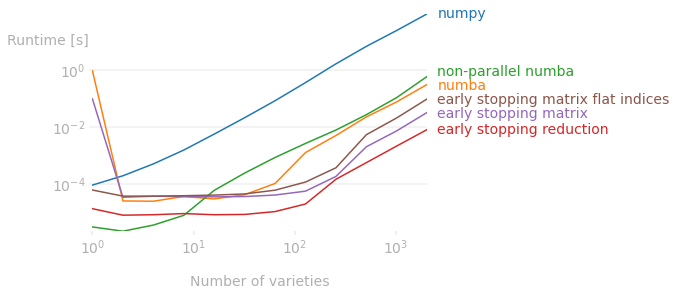

In [8]:
rng = np.random.default_rng(seed = 1)
nrows = 100 # number of different patterns to investigate

perfplot.show(
    setup=lambda n: rng.choice([0, 1, 2, -1], (nrows, n), p = [1/4, 1/4, 1/4, 1/4]),
    kernels=[
        lambda a: calculate_best_possible_score_numpy(a),
        lambda a: calculate_best_possible_score_numba(a),
        lambda a: calculate_best_possible_score_numba_nonparallel(a),
        lambda a: calculate_best_possible_score_earlyend_reduce(a),
        lambda a: calculate_best_possible_score_earlyend_matrix(a),
        lambda a: calculate_best_possible_score_earlyend_matrix_flatindex(a),
    ],
    labels=["numpy", "numba", "non-parallel numba", "early stopping reduction", "early stopping matrix", "early stopping matrix flat indices"],
    n_range=[2**k for k in range(12)],
    xlabel="Number of varieties",
    # More optional arguments with their default values:
    # logx="auto",  # set to True or False to force scaling
    # logy="auto",
    # equality_check=np.allclose,  # set to None to disable "correctness" assertion
    # show_progress=True,
    # target_time_per_measurement=1.0,
    # max_time=None,  # maximum time per measurement
    # time_unit="s",  # set to one of ("auto", "s", "ms", "us", or "ns") to force plot units
    # relative_to=1,  # plot the timings relative to one of the measurements
    # flops=lambda n: 3*n,  # FLOPS plots
)

1000 different patterns for increasing numbers of variation

Output()

(4.900000000000002e-06, 1018.1227293999998)


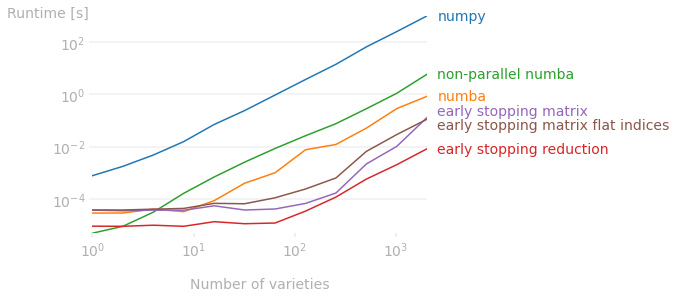

In [12]:
rng = np.random.default_rng(seed = 1)
nrows = 1000 # number of different patterns to investigate

perfplot.show(
    setup=lambda n: rng.choice([0, 1, 2, -1], (nrows, n), p = [1/4, 1/4, 1/4, 1/4]),
    kernels=[
        lambda a: calculate_best_possible_score_numpy(a),
        lambda a: calculate_best_possible_score_numba(a),
        lambda a: calculate_best_possible_score_numba_nonparallel(a),
        lambda a: calculate_best_possible_score_earlyend_reduce(a),
        lambda a: calculate_best_possible_score_earlyend_matrix(a),
        lambda a: calculate_best_possible_score_earlyend_matrix_flatindex(a),
    ],
    labels=["numpy", "numba", "non-parallel numba", "early stopping reduction", "early stopping matrix", "early stopping matrix flat indices"],
    n_range=[2**k for k in range(12)],
    xlabel="Number of varieties",
    # More optional arguments with their default values:
    # logx="auto",  # set to True or False to force scaling
    # logy="auto",
    # equality_check=np.allclose,  # set to None to disable "correctness" assertion
    # show_progress=True,
    # target_time_per_measurement=1.0,
    # max_time=None,  # maximum time per measurement
    # time_unit="s",  # set to one of ("auto", "s", "ms", "us", or "ns") to force plot units
    # relative_to=1,  # plot the timings relative to one of the measurements
    # flops=lambda n: 3*n,  # FLOPS plots
)

10000 different patterns for increasing numbers of variation

Output()

(7.800000000000007e-06, 55.5897144)


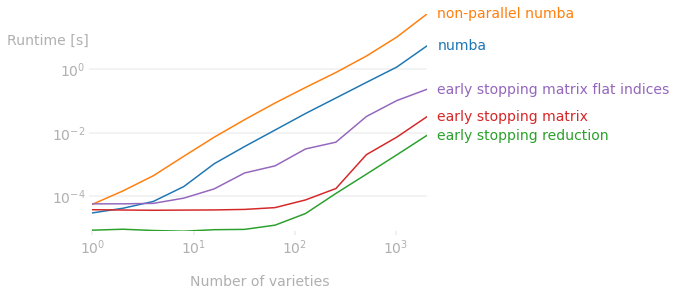

In [10]:
rng = np.random.default_rng(seed = 1)
nrows = 10000 # number of different patterns to investigate

perfplot.show(
    setup=lambda n: rng.choice([0, 1, 2, -1], (nrows, n), p = [1/4, 1/4, 1/4, 1/4]),
    kernels=[
        lambda a: calculate_best_possible_score_numba(a),
        lambda a: calculate_best_possible_score_numba_nonparallel(a),
        lambda a: calculate_best_possible_score_earlyend_reduce(a),
        lambda a: calculate_best_possible_score_earlyend_matrix(a),
        lambda a: calculate_best_possible_score_earlyend_matrix_flatindex(a),
    ],
    labels=["numba", "non-parallel numba", "early stopping reduction", "early stopping matrix", "early stopping matrix flat indices"],
    n_range=[2**k for k in range(12)],
    xlabel="Number of varieties",
    # More optional arguments with their default values:
    # logx="auto",  # set to True or False to force scaling
    # logy="auto",
    # equality_check=np.allclose,  # set to None to disable "correctness" assertion
    # show_progress=True,
    # target_time_per_measurement=1.0,
    # max_time=None,  # maximum time per measurement
    # time_unit="s",  # set to one of ("auto", "s", "ms", "us", or "ns") to force plot units
    # relative_to=1,  # plot the timings relative to one of the measurements
    # flops=lambda n: 3*n,  # FLOPS plots
)

100000 different patterns for increasing numbers of variation

Output()

(7.900000000000007e-06, 569.044046)


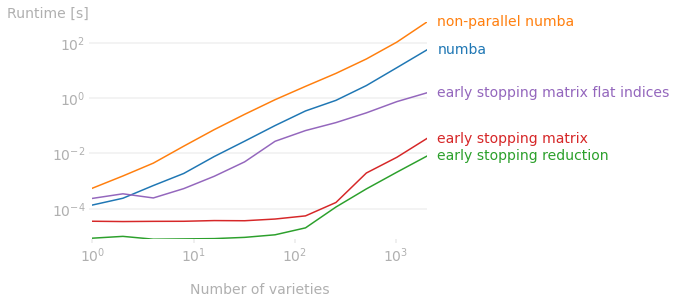

In [11]:
rng = np.random.default_rng(seed = 1)
nrows = 100000 # number of different patterns to investigate

perfplot.show(
    setup=lambda n: rng.choice([0, 1, 2, -1], (nrows, n), p = [1/4, 1/4, 1/4, 1/4]),
    kernels=[
        lambda a: calculate_best_possible_score_numba(a),
        lambda a: calculate_best_possible_score_numba_nonparallel(a),
        lambda a: calculate_best_possible_score_earlyend_reduce(a),
        lambda a: calculate_best_possible_score_earlyend_matrix(a),
        lambda a: calculate_best_possible_score_earlyend_matrix_flatindex(a),
    ],
    labels=["numba", "non-parallel numba", "early stopping reduction", "early stopping matrix", "early stopping matrix flat indices"],
    n_range=[2**k for k in range(12)],
    xlabel="Number of varieties",
    # More optional arguments with their default values:
    # logx="auto",  # set to True or False to force scaling
    # logy="auto",
    # equality_check=np.allclose,  # set to None to disable "correctness" assertion
    # show_progress=True,
    # target_time_per_measurement=1.0,
    # max_time=None,  # maximum time per measurement
    # time_unit="s",  # set to one of ("auto", "s", "ms", "us", or "ns") to force plot units
    # relative_to=1,  # plot the timings relative to one of the measurements
    # flops=lambda n: 3*n,  # FLOPS plots
)